# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 06.10.2021

Мягкий дедлайн: 23:59MSK 25.10.2021

Жесткий дедлайн: 23:59MSK 28.10.2021

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-10-26 21:39:41--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 211011981 (201M) [application/x-httpd-php]
Сохранение в: «data.txt.zip»

data.txt.zip        100%[===================>] 201,24M  4,01MB/s    за 48s     

2021-10-26 21:40:30 (4,19 MB/s) - «data.txt.zip» сохранён [211011981/211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [4]:
from sklearn.linear_model import Ridge
from sklearn import metrics
from tqdm.auto import tqdm
import torch.utils.data as data_utils
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [6]:
std_y_train = np.std(y_train) # отдельно нормализируем y_train по формуле
mean_y_train = np.mean(y_train)

y_train = (y_train - mean_y_train) / std_y_train

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

scaler = StandardScaler()
scaler.fit(X_test)
X_test = scaler.transform(X_test)

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [9]:
ridge = Ridge() # посчитаем Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test) * std_y_train + mean_y_train

metrics.mean_squared_error(y_test, y_pred, squared=False)

9.51267116131314

In [10]:
metrics.mean_squared_error(y_test, np.median(y_test) * np.ones(y_test.shape), squared=False)

11.403668567118597

In [11]:
metrics.mean_squared_error(y_test, np.mean(y_test) * np.ones(y_test.shape), squared=False)

10.851909820717683

## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [51]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_random_seed(99)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [71]:
# создадим трейн и тест
train_set =  data_utils.TensorDataset(torch.tensor(
    X_train, 
    dtype=torch.float32), 
    torch.tensor(y_train, dtype=torch.float32))

train_dataloader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=300, 
    shuffle=True, 
    drop_last=False)

test_set =  data_utils.TensorDataset(torch.tensor(
    X_test, 
    dtype=torch.float32), 
    torch.tensor(y_test, dtype=torch.float32))

test_dataloader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=100, 
    shuffle=False, 
    drop_last=False)

In [147]:
# создадим нейронную сеть
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_hidden_1, n_hidden_2, n_hidden_3, n_output):
        super(Net, self).__init__()
        
        
        self.fc1 = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.b1 = nn.BatchNorm1d(n_hidden)
        self.act1 = torch.nn.LeakyReLU()
        
        
        self.d1 = nn.Dropout(p=0.6)
        self.fc2 = torch.nn.Linear(n_hidden, n_hidden_1)    # output layer
        self.b2 = nn.BatchNorm1d(n_hidden_1)
        self.act2 = torch.nn.LeakyReLU()
        
        self.d2 = nn.Dropout(p=0.6)
        self.fc3 = torch.nn.Linear(n_hidden_1, n_hidden_2)    # output layer
        self.b3 = nn.BatchNorm1d(n_hidden_2)
        self.act3 = torch.nn.LeakyReLU()
        
        self.d3 = nn.Dropout(p=0.3)
        self.fc4 = torch.nn.Linear(n_hidden_2, n_hidden_3)    # output layer
        self.b4 = nn.BatchNorm1d(n_hidden_3)
        self.act4 = torch.nn.LeakyReLU()
        
        
        self.d4 = nn.Dropout(p=0.3)
        self.fc5 = torch.nn.Linear(n_hidden_3, n_output)

    def forward(self, x):
        x = self.fc1(x) 
        x = self.b1(x)
        x = self.act1(x)
        
        x = self.d1(x)
        x = self.fc2(x) 
        x = self.b2(x)
        x = self.act1(x)
        
        x = self.d2(x)
        x = self.fc3(x) 
        x = self.b3(x)
        x = self.act2(x)
        
        x = self.d3(x)
        x = self.fc4(x) 
        x = self.b4(x)
        x = self.act3(x)
        
        x = self.d4(x)
        x= self.fc5(x)
        return x
    
model = Net(n_feature=90, n_hidden=100, n_hidden_1=70, n_hidden_2=40, n_hidden_3=20, n_output=1) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) #
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)

In [156]:
def train(model, optimizer,criterion, train_loader, test_loader, std, mean):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''

    loss_list = []
    # обучение
    for epoch in range(5):
        model.train()
        for imgs, labels in tqdm(train_dataloader, desc=f"Training, epoch {epoch}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            
            y_pred = # your code here
            loss = # your code here
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # log loss for the current epoch and the whole training history
            train_epoch_loss = torch.cat((train_epoch_loss, loss.unsqueeze(0) / labels.size(0)))
            train_loss_log.append(loss.data / labels.size(0))

            # log accuracy for the current epoch and the whole training history
            pred_classes = torch.argmax(y_pred, dim=-1)
            train_epoch_true_hits = torch.cat((
                train_epoch_true_hits, 
                (pred_classes == labels).sum().unsqueeze(0)
            ))
            train_acc_log.append((pred_classes == labels).cpu().sum() / labels.shape[0])


        # валидация
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(val_dataloader, desc=f"Validating, epoch {epoch}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device)
                
                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat((val_epoch_loss, loss.unsqueeze(0) / labels.size(0)))

                pred_classes = torch.argmax(y_pred, dim=-1)
                val_epoch_true_hits = torch.cat((
                    val_epoch_true_hits,
                    (pred_classes == labels).sum().unsqueeze(0)
                ))
        
        
        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size)
        clear_output()
        plot_history(train_loss_log, val_loss_log, "loss")
        plot_history(train_acc_log, val_acc_log, "accuracy")

        print("Train loss:", train_epoch_loss.mean().item())
        print(
            "Train acc:", 
            (train_epoch_true_hits.sum() / train_epoch_true_hits.size(0) / train_dataloader.batch_size).item()
        )
        print("Val loss:", val_epoch_loss.mean().item())
        print(
            "Val acc:", 
            (val_epoch_true_hits.sum() / val_epoch_true_hits.size(0) / val_dataloader.batch_size).item()
        )
            
        # ошибка на валидации    
        if epoch % 1 == 0:
            with torch.no_grad():
                for X_test, y_test in tqdm(test_loader):
                    y_pred = (model(X_test))[:, 0]
                    y_pred = y_pred * std + mean
                    loss = criterion(y_pred, y_test)
                    val_loss.append(loss.numpy())

            print(f"Epoch: {epoch}, val_loss: {np.sqrt(np.mean(val_loss))}")
            loss_list.append(np.sqrt(np.mean(val_loss)))
            
        scheduler.step()
    # график     
    ax = sns.lineplot(np.arange(len(loss_list)), np.array(loss_list))
    ax.set(xlabel='Epoch', ylabel='Loss')
    sns.set(rc = {'figure.figsize': (10, 10)})

    # raise NotImplementedError

def test(model, criterion, test_loader, std, mean):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''    
    model.eval()
    predicts = torch.tensor([])
    loss_list = []
    # тест
    for X_test, y_test in tqdm(test_loader):
        predicts = torch.cat((predicts, model(X_test)), 0) 
        loss = criterion(predicts * std + mean, y_test)
        loss_list.append(loss.detach().numpy())
    #график
    ax = sns.lineplot(np.arange(len(loss_list)), np.array(loss_list))
    ax.set(xlabel='Epoch', ylabel='Loss')
    sns.set(rc = {'figure.figsize': (10, 10)})
    predicts = predicts * std + mean
    return predicts

  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

Epoch: 0, val_loss: 8.843454360961914


  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

Epoch: 1, val_loss: 8.795221328735352


  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

Epoch: 2, val_loss: 8.785449028015137


  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

Epoch: 3, val_loss: 8.795376777648926


  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/517 [00:00<?, ?it/s]

Epoch: 4, val_loss: 8.761459350585938


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


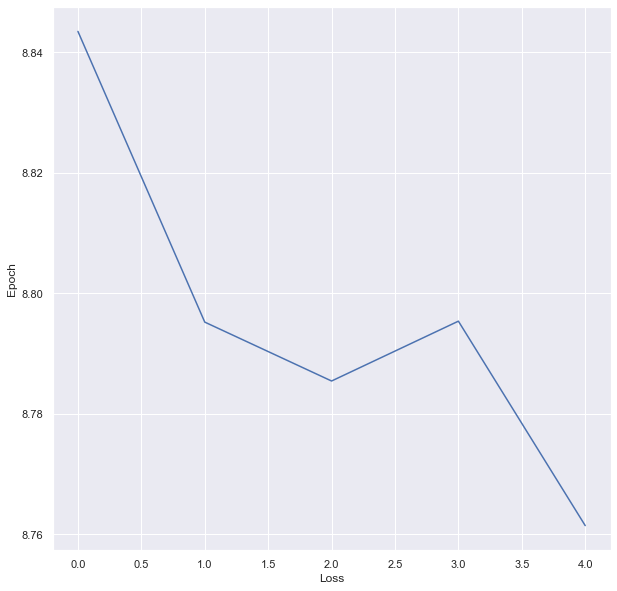

In [149]:
train(model, optimizer, criterion, train_dataloader, test_dataloader, std_y_train, mean_y_train)

  0%|          | 0/517 [00:00<?, ?it/s]

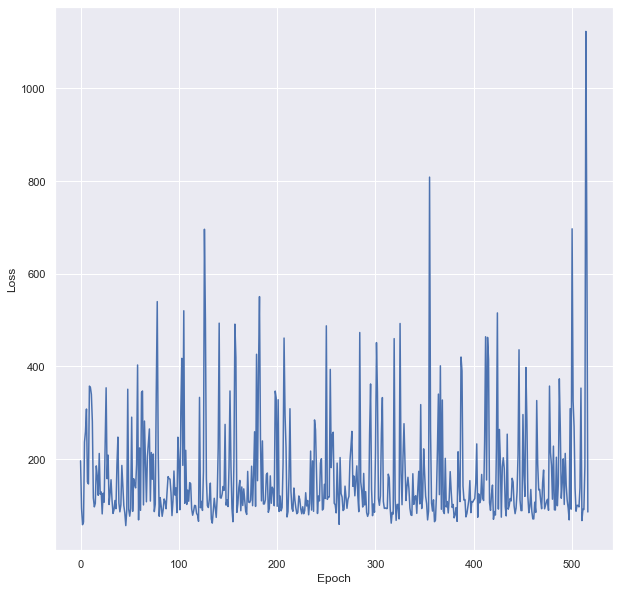

In [161]:
y_preds = (test(model, criterion, test_dataloader, std_y_train, mean_y_train))

In [151]:
y_t = torch.tensor(y_test, dtype=torch.float32).detach().numpy()
y_p = y_preds.reshape(len(y_test),).detach().numpy()
metrics.mean_squared_error(y_t, y_p, squared=False)

8.765073

In [153]:
assert test(model, criterion, test_dataloader, std_y_train, mean_y_train).shape[0] == y_test.shape[0]

  0%|          | 0/517 [00:00<?, ?it/s]

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

In [ ]:
# отчет:
# шаг первый - я ниче не поняла
# шаг второй - я посмотрела семинар и все равно ничего не поняла
# шаг третий - я почитала статьи, понимание стало появляться
# попробовала код с семинара - запуталась в матрицах и обозначениях, решила, что все нужно писать с нуля
# написала по этому видосу: https://www.youtube.com/watch?v=khvO24NWZsc&t=2768s 
# было два слоя relu, и два линейных слоя
# начала эксперименты: 
# сначала долго не могла понять, почему не хочет считать среднюю ошибку - оказалось, что уже на 10-ой итерации ошибка улетала в космос (бесконечность),
# уменьшила лосс до 0.0001 - все стало ок
# попробовала убрать выбросы (как правило, все что раньше 50-ых и 2011) - стало хуже
# попробовала стандартизировать и нормализировать вместе с таргетом - стало хуже, таргет вернула в изначальное значение, остальное - оставила
# начала экспериментировать с архитектурой - добавила третий слой - нет, 4 слой - нет
# пробовала разные оптимизаторы (ADAGRAD, Adam, LBFGS), отдельные настройки для lr (torch.optim.lr_scheduler.StepLR, lr_scheduler.MultiStepLR) - 
# ниже 10 не опускалось


# вот некоторые из экспериментов:
# 90 50 20 - 9.22(5 эпшх), 9.14(8), 9,04(10)
# 50 100 - 9.18 (5)
# 50 50 9.18 (5 эпох) 8.909265666548915 (20) 8.89012647938593 (25) batch 1000
# 90 100 50 (20) 8.892263885175295 (25) 8.870764587352271 c рег batch 1000
# 90 100 50 (20) 8.892263885175295 (25) 8.870764587352271 c рег 1e-5 batch 1000
# 90 100 50 8.997302309954119 (10) 8.944407772444219 (15) 8.91183532389358 (20)c reg 1e-6 batch 1000
# 90 100 50 8.99960210469999 (5) batch 300



# до этого все мои модели учились около часа-двух (10 минут за эпоху), потому что я создавала не через data_utils
# когда до меня дошло, что можно решать задачу в 60 раз быстрее, стало намного проще)))
# так же я отказалась от нормализации через Standartscaller и сделалал через mean и std по формуле

# я все еще не могла опуститься ниже 9, поэтому сначала добавила 4-ый слой, а потом и 5-ый
# модель стала опускаться сразу к нужной оценке
# но ее стало сильно шатать из стороны в сторону, поэтому я стала настраивать регуляризацию и dropout
# последним добавила sheduler для стабильности
